# OTOC's in dual-unitary circuits

In [1]:
%matplotlib inline

#Load necessary packages
import math
import numpy as np
from scipy.stats import unitary_group
from scipy.linalg import eigh, expm
import matplotlib.pyplot as plt

In [2]:
#Aesthetics
np.set_printoptions(precision=4)
fig_size =  [12, 8]

params = {'backend': 'ps',
      'axes.labelsize': 14,
      'font.size': 14,
      'legend.fontsize': 13,
      'axes.titlesize' : 12,
      'xtick.labelsize': 12,
      'ytick.labelsize': 12,
      'axes.linewidth' : 1.,
      'axes.linewidth' : 1.,
      'lines.linewidth' : 2.,
      'text.usetex': True,
      'figure.figsize': fig_size}
plt.rcParams.update(params)

![Definitions](definition_UUdag.png)

In [3]:
#Define unitary gates

"""
Unitaries defined as going forward in time, with U(a,b,c,d) for KIM given by

-0.5 * 1j * np.exp(1j*np.pi/4.*(a-d)*(c-b))*np.exp(-1j*h_1*(a+c)/2.-1j*h_2*(b+d)/2.)

where a,b,c,d \in {1,-1} (in array-notation {1,0})

a   b
|   |
-----
| U |
-----
|   |
c   d
"""

#Define gate for Kicked Ising Model
def KIM_gate():
    J = np.pi/4.
    b = np.pi/4.
    h_1 = 0.2
    h_2 = 0.7
    X = np.array([[0,1], [1, 0]])
    Z = np.array([[1,0], [0, -1]])
    X_exp = np.cos(b) * np.identity(2) - 1j * np.sin(b) * X
    Z_1_exp = np.cos(0.5*h_1) * np.identity(2) - 1j * np.sin(0.5*h_1) * Z
    Z_2_exp = np.cos(0.5*h_2) * np.identity(2) - 1j * np.sin(0.5*h_2) * Z
    
    ZZ = np.einsum("ac,bd->abcd", Z, Z)
    IdId = np.einsum("ac,bd->abcd", np.identity(2), np.identity(2))
    ZZ_exp = np.cos(J) * IdId - 1j * np.sin(J) * ZZ

    K_1 = np.einsum('ab,bc,cd->ad',Z_1_exp,X_exp,Z_1_exp)
    K_2 = np.einsum('ab,bc,cd->ad',Z_2_exp,X_exp,Z_2_exp)
    return np.einsum("abcd,ce,df,efjk", ZZ_exp, K_1, K_2, ZZ_exp)

#Define general dual-unitary gate
def dual_unitary_gate(J, phi):
    Id = np.array([[1,0],[0,1]])
    X = np.array([[0,1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1,0], [0, -1]])

    sigma = [X,Y,Z]

    M = 0.25*np.pi*(np.einsum('ac,bd->abcd', X, X)+np.einsum('ac,bd->abcd', Y, Y))-J*np.einsum('ac,bd->abcd', Z, Z)
    V = (expm(-1j*M.reshape(4,4))).reshape([2,2,2,2])
    
    #Add random SU(2) element to each leg
    n_u_p = np.random.rand(3)
    n_u_p = n_u_p/(np.linalg.norm(n_u_p))
    theta_u_p = np.random.rand()
    
    n_u_m = np.random.rand(3)
    n_u_m = n_u_m/(np.linalg.norm(n_u_m))
    theta_u_m = np.random.rand()
    
    n_v_p = np.random.rand(3)
    n_v_p = n_v_p/(np.linalg.norm(n_v_p))
    theta_v_p = np.random.rand()
    
    
    n_v_m = np.random.rand(3)
    n_v_m = n_v_m/(np.linalg.norm(n_v_m))
    theta_v_m = np.random.rand()
    
    u_plus = np.cos(theta_u_p) * Id + 1j*np.sin(theta_u_p) * np.sum([n_u_p[i]*sigma[i] for i in range(3)],axis=0)
    u_min = np.cos(theta_u_m) * Id + 1j*np.sin(theta_u_m) * np.sum([n_u_m[i]*sigma[i] for i in range(3)],axis=0)
    v_plus = np.cos(theta_v_p) * Id + 1j*np.sin(theta_v_p) * np.sum([n_v_p[i]*sigma[i] for i in range(3)],axis=0)
    v_min = np.cos(theta_v_m) * Id + 1j*np.sin(theta_v_m) * np.sum([n_v_m[i]*sigma[i] for i in range(3)],axis=0)
    
    U = np.exp(1j*phi) * np.einsum( 'ac,bd,cdef,eg,fh-> abgh' ,u_plus, u_min, V, v_plus, v_min)
    return(U)


#Represent unitaries as matrices rather than tensors
def tensor_to_matrix(tensor):
    #Given tensor T_abcd...efgh... returns matrix M_{abcd..., efgh...}
    num_row_indices = len(tensor.shape) // 2
    q = tensor.shape[0]
    return tensor.reshape(2 * [q ** num_row_indices])

def tensor_to_vector(tensor):
    #Given tensor T_abcd... returns vector V_{abcd...}
    num_row_indices = len(tensor.shape) 
    q = tensor.shape[0]
    return tensor.reshape([q ** num_row_indices])


The diagram of the OTOC depends on the parity of the distance from the lightcone $x-t$. 

For $x-t$ is even, the OTOC is given by


<img src="OTOC_even.png" alt="Drawing" style="width: 600px;"/>


\begin{equation}
n_+ = \frac{1}{2}\left[t+(x-y)\right], \qquad n_- = \frac{1}{2}\left[(t+2)-(x-y)\right].
\end{equation}

For operators where $x-t$ is odd, the OTOC is given by

<img src="OTOC_odd.png" alt="Drawing" style="width: 600px;"/>


\begin{equation}
n_+ = \frac{1}{2}\left[(t+1)+(x-y)\right], \qquad n_- = \frac{1}{2}\left[(t+1) - (x-y)\right].
\end{equation}



In [4]:
#Define necessary operators 

Id = np.array([[1,0],[0,1]])
X = np.array([[0,1], [1, 0]])
Z = np.array([[1,0], [0, -1]])

#Define transfer matrix, left and right boundaries

"""
Transfer matrix defined as going from right to left
T_{ab...cd ef...gh}     R_{ab...cd}        L_{ab...cd}

a-|---|-e                a-|---|            |---|-a   
b-|   |-f                b-|   |            |   |-b
: |   | :                : |   |            |   | :
: | T | :                : | R |            | L | :
c-|   |-g                c-|   |            |   |-c
d-|---|-h                d-|---|            |---|-d
"""

def construct_T(U, n_t):
    #Construct T for a fixed number of layers n_t
    #Returns (4 n_t * 4 n_t tensor with each leg having dimension q)
    
    q = U.shape[0]
    
    #Builds up the transfer matrix from the bottom
    #First layer of U's
    T = np.einsum('astb-> sabt',U)
    for i in range(n_t-1):
        T = np.einsum('asub,u...t -> sa...bt',U,T)
    #First layer of U^{\dag}'s'
    for i in range(n_t):
        T = np.einsum('ausb,u...t -> sa...bt',np.conj(U),T)
    #Second layer of U's
    for i in range(n_t):
        T = np.einsum('asub,u...t -> sa...bt',U,T)
    #Second layer of U^{\dag}'s
    for i in range(n_t):
        T = np.einsum('ausb,u...t -> sa...bt',np.conj(U),T)
        
    #Final contraction along vertical axis
    T = np.einsum('s...s -> ...', T) 
    #Reorder right-hand side indices
    ind = list(range(1,4*n_t+1)) + list(range(8*n_t,4*n_t,-1))
    T = np.einsum(T,ind)
    return T / q

def construct_L(op_L, n_t):
    #Construct left boundary for a fixed number of layers n_t
    #Returns 4 n_t * 1 tensor with each leg having dimension q
    
    q = op_L.shape[0]
    
    L = np.einsum('ab -> ab', op_L)    #Start with operator, keeping indices explicit
    for i in range(n_t-1):
        L = np.einsum('ab, ... -> a...b', Id, L)    #Pad with identities   
    #L = np.einsum('..., ab -> ...ab', L, op_L)    #Add operator
    #for i in range(n_t-1):
    #    L = np.einsum('...bc, ad -> ...abcd', L, Id)    #Pad with identities   
    ind_1 = list(range(1,2*n_t+1))
    ind_2 = list(range(2*n_t+1,4*n_t+1))
    L = np.einsum(L, ind_1, L, ind_2)
    return L / np.sqrt(q**n_t)

def construct_R_even(op_R, n_t):
    #Construct right boundary for a fixed number of layers n_t and even parity
    #Returns 4 n_t vector
    
    q = op_R.shape[0]
    
    R = np.einsum('ab -> ab', op_R)    #Start with operator, keeping indices explicit
    for i in range(n_t-1):
        R = np.einsum('ab, ... -> a...b', Id, R)    #Pad with identities
    for i in range(n_t-1):
        R = np.einsum('ba, ... -> a...b', Id, R)    #Pad with identities
    R = np.einsum('ba, ... -> a...b', op_R, R)    #Add operator
    return R / np.sqrt(q**n_t)

def construct_R_odd(op_R, U, n_t):
    #Construct right boundary for a fixed number of layers n_t and odd parity
    #Express as transfer matrix with additional operators
    
    q = U.shape[0]
    
    #Builds up the transfer matrix from the bottom
    #First layer of U's building on operator 
    T_r = np.einsum('tu,asub-> sabt', op_R, U)
    for i in range(n_t-1):
        T_r = np.einsum('asub,u...t -> sa...bt',U,T_r)
    #First layer of U^{\dag}'s'
    for i in range(n_t):
        T_r = np.einsum('ausb,u...t -> sa...bt',np.conj(U),T_r)
    #Introduce operator
    T_r = np.einsum('su,u...t -> s...t',op_R,T_r)
    #Second layer of U's
    for i in range(n_t):
        T_r = np.einsum('asub,u...t -> sa...bt',U,T_r)
    #Second layer of U^{\dag}'s
    for i in range(n_t):
        T_r = np.einsum('ausb,u...t -> sa...bt',np.conj(U),T_r)
        
    #Final contraction along vertical axis
    T_r = np.einsum('s...s -> ...', T_r) 
    #Reorder right-hand side indices
    ind = list(range(1,4*n_t+1)) + list(range(8*n_t,4*n_t,-1))
    
    T_r = np.einsum(T_r,ind)
    R =  mult_tens_vec(T_r,construct_R_even(Id,n_t)) / q
    return R

In [5]:
#Define contraction of tensors and/or vectors

def inner_product(vec_1, vec_2):
    #Calculate inner product of two vectors
    assert(vec_1.shape == vec_2.shape)
    num_indices = len(vec_1.shape)
    return np.tensordot(vec_1.conj(), vec_2, axes=num_indices)

def mult_tens_vec(tens,vec):
    #Apply tensor to vector
    assert(vec.shape + vec.shape == tens.shape)
    n_ind = len(vec.shape)
    vec_cont = np.einsum(tens, list(range(1,2*n_ind+1)), vec, list(range(n_ind+1,2*n_ind+1)))
    return vec_cont
    
def mult_vec_vec(vec_1,vec_2):
    #Contract two vectors
    assert(vec_1.shape == vec_2.shape)
    n_ind = len(vec_1.shape)
    ind = list(range(1,n_ind+1))
    return np.einsum(vec_1, ind, vec_2, ind)

#Represent unitaries as matrices rather than tensors
def tensor_to_matrix(tensor):
    #Given tensor T_abcd...efgh... returns matrix M_{abcd..., efgh...}
    num_row_indices = len(tensor.shape) // 2
    q = tensor.shape[0]
    return tensor.reshape(2 * [q ** num_row_indices])

def tensor_to_vector(tensor):
    #Given tensor T_abcd... returns vector V_{abcd...}
    num_row_indices = len(tensor.shape) 
    q = tensor.shape[0]
    return tensor.reshape([q ** num_row_indices])


In [6]:
#Verify  construction of transfer matrix and boundaries by comparing with explicit construction for n_t = 1,2

U = KIM_gate()
op_L, op_R = X, X

print("Verifying transfer matrix")
T_1 = construct_T(U,1) * 2.
[E_1,_] = np.linalg.eig(tensor_to_matrix(T_1)) 


T_1_t = np.einsum('amqe,bmnf,cpnj,dpqk->abcdefjk',np.conj(U),U,np.conj(U),U) 
[E_1_t,_] = np.linalg.eig(tensor_to_matrix(T_1))
print("Should be zero:", np.linalg.norm(np.sort(np.abs(E_1))-np.sort(np.abs(E_1_t))))

T_2 = construct_T(U,2) * 2.
[E_2,_] = np.linalg.eig(tensor_to_matrix(T_2))
A_t = np.einsum('aish,bjig,cjkf,dkte -> sabcdhgfet',np.conj(U),np.conj(U),U,U)
T_2_t =  tensor_to_matrix(np.einsum('sabcdefght,tijklmnops -> abcdijklefghmnop',A_t,A_t) ) 
[E_2_t,_] = np.linalg.eig(T_2_t)
print("Should be zero:", np.linalg.norm(np.sort(np.abs(E_2))-np.sort(np.abs(E_2_t))))

print("\nVerifying left boundary")
op_L = X
L_1 = construct_L(op_L,1) * np.sqrt(2.)
print("Should be zero: ", np.linalg.norm(L_1 - np.einsum('ab,cd -> abcd',op_L,op_L)))
L_2 = construct_L(op_L,2) * 2.
print("Should be zero:", np.linalg.norm(L_2 - np.einsum('ad,bc,eh,fg -> abcdefgh',Id,op_L,Id,op_L)))

L_3 = construct_L(op_L,3) * np.sqrt(8)
L_3_t = np.einsum('af,be,cd,gl,hk,ij -> abcdefghijkl',Id,Id,op_L,Id,Id,op_L)
print("Should be zero:", np.linalg.norm(L_3-L_3_t))

print("\nVerifying right boundary")
op_R = X
R_1 = construct_R_even(op_R,1) * np.sqrt(2.)
print("Should be zero: ", np.linalg.norm(R_1 - np.einsum('ad,bc -> abcd',op_R,op_R)))
R_2 = construct_R_even(op_R,2) * 2.
print("Should be zero:", np.linalg.norm(R_2 - np.einsum('ha,gb,cf,de -> abcdefgh',op_R,Id,Id,op_R)))

R_3 = construct_R_even(op_R,3) * np.sqrt(8)
R_3_t = np.einsum('al,bk,cj,di,eh,fg->abcdefghijkl',op_R,Id,Id,Id,Id,op_R)
print("Should be zero:", np.linalg.norm(R_3-R_3_t))

Verifying transfer matrix
Should be zero: 0.0
Should be zero: 2.6751072031298784e-14

Verifying left boundary
Should be zero:  0.0
Should be zero: 0.0
Should be zero: 0.0

Verifying right boundary
Should be zero:  0.0
Should be zero: 0.0
Should be zero: 0.0


In [7]:
#Verify multiplication by comparing with explicit construction for n_t = 1,2
print("Verifying multiplication")
T = construct_T(U,1)
R = construct_R_even(op_R,1)
L = construct_L(op_R,1)

print("Should be zero:", np.linalg.norm(mult_tens_vec(T,R) - np.einsum('abcdefgh,efgh -> abcd',T,R)))
print("Should be zero:", np.linalg.norm(mult_vec_vec(L,R) - np.einsum('abcd,abcd',L,R)))

T = construct_T(U,2)
R = construct_R_even(op_R,2)
L = construct_L(op_L,2)

print("Should be zero:", np.linalg.norm(mult_tens_vec(T,R) - np.einsum('abcdefghijklmnop,ijklmnop -> abcdefgh',T,R)))
print("Should be zero:", np.linalg.norm(mult_vec_vec(L,R) - np.einsum('abcdefgh,abcdefgh',L,R)))

print("Should be zero:", np.linalg.norm(mult_tens_vec(T,R) - np.einsum('abcdefghijklmnop,ijklmnop -> abcdefgh',T,R)))
print("Should be zero:", np.linalg.norm(mult_vec_vec(L,R) - np.einsum('abcdefgh,abcdefgh',L,R)))

Verifying multiplication
Should be zero: 0.0
Should be zero: 0.0
Should be zero: 0.0
Should be zero: 0.0
Should be zero: 0.0
Should be zero: 0.0


In [8]:
#Perform evolution through tensor contraction

#(x-t) even
def evol_even(U, op_L, op_R, n_l, n_t):
    t_range = np.arange(n_t)
    OTOC_range = np.zeros(n_t,dtype=complex)
    
    q = U.shape[0]
    T_tens = construct_T(U, n_l)
    R_vec = construct_R_even(op_R, n_l)
    L_vec = construct_L(op_L, n_l)
    
    t_vec = R_vec
    for t_i in t_range:
        OTOC_range[t_i] = mult_vec_vec(L_vec, t_vec)
        #print(OTOC_range[t_i])
        new_vec  = mult_tens_vec(T_tens, t_vec)
        t_vec = new_vec
    return [t_range,OTOC_range]


#(x-t) odd
def evol_odd(U, op_L, op_R, n_l, n_t):
    t_range = np.arange(n_t)
    OTOC_range = np.zeros(n_t,dtype=complex)
    
    q = U.shape[0]
    T_tens = construct_T(U, n_l)
    R_vec = construct_R_odd(op_R, U, n_l)
    L_vec = construct_L(op_L, n_l)
    
    t_vec = R_vec
    OTOC_range[0] = 0.
    for t_i in t_range[1:]:
        OTOC_range[t_i] = mult_vec_vec(L_vec, t_vec)
        #print(OTOC_range[t_i])
        new_vec  = mult_tens_vec(T_tens, t_vec)
        t_vec = new_vec
    return [t_range,OTOC_range]


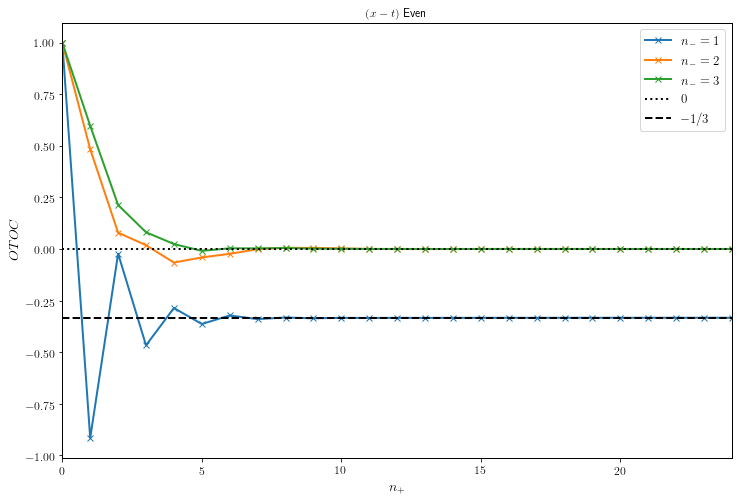

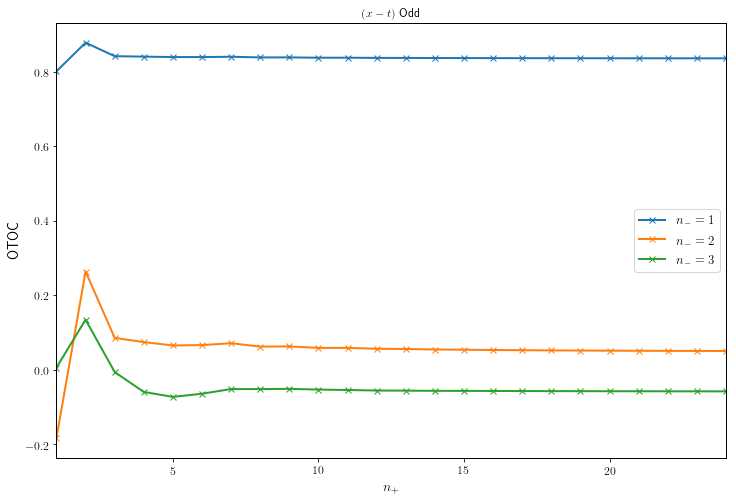

In [9]:
#Illustrate evolution

#U = KIM_gate()
U = dual_unitary_gate(1.7,2.)
op_L, op_R = X,X
n_t = 25

plt.figure()
for n_l in range(1,4):
    [t_range, OTOC_range] = evol_even(U, op_L, op_R, n_l, n_t)
    plt.plot(t_range,OTOC_range.real,'x-',label=r'$n_{-}=%s$'%n_l)
    
plt.plot([0.]*n_t,'k:',label='$0$')
plt.plot([-1./3.]*n_t,'k--',label='$-1/3$')
plt.title(r'$(x-t)$ Even')
plt.xlabel(r'$n_{+}$')
plt.ylabel(r'$OTOC$')
plt.xlim(0,n_t-1)
plt.legend()
plt.show()

plt.figure()
for n_l in range(1,4):
    [t_range, OTOC_range] = evol_odd(U, op_L, op_R, n_l, n_t)
    plt.plot(t_range,OTOC_range.real,'x-',label=r'$n_{-}=%s$'%n_l)
    #print(OTOC_range.real[-1])

plt.title(r'$(x-t)$ Odd ')
plt.xlabel(r'$n_+$')
plt.ylabel(r'OTOC')
plt.xlim(1,n_t-1)
plt.legend()
plt.show()    

In [10]:
#Define quantum channels for steady-state OTOC values
def M_channel_1(op, U):
    q = U.shape[0]
    return np.einsum('eacf, cd, ebdf  -> ab', U, op, np.conj(U)) / q

def M_channel_2(op, U):
    q = U.shape[0]
    return np.einsum('ecaf, cd, edbf  -> ab', np.conj(U), op, U) / q

def M_n(op, U, n):
    q = U.shape[0]
    M_init = op
    for i in range(n):
        M_init = M_channel_1(M_init, U)
    for i in range(n):
        M_init = M_channel_2(M_init, U)
    return (np.einsum('ab,ba', M_init, op) / q)

def OTOC_ss(op, U, n):
    q = U.shape[0]
    return (q**2 * M_n(op, U, n) - M_n(op, U, n-1))/(q**2-1.)
    

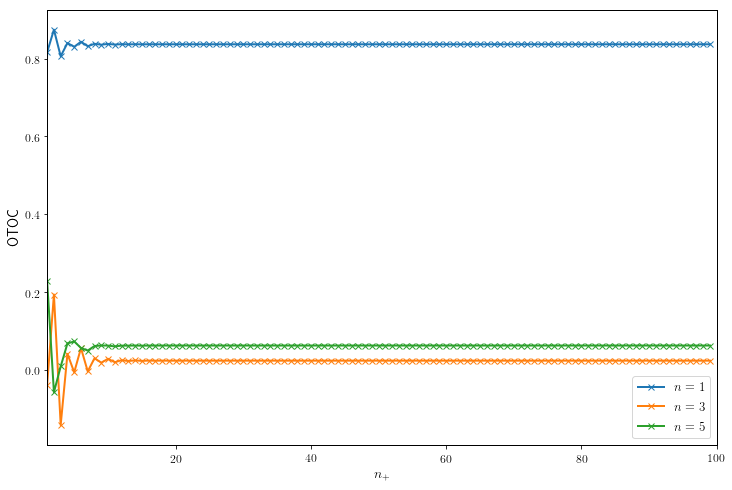

Stationary values from explicit calculation (limited to small n):
 [0.8369 0.0228 0.0617]
Stationary values from quantum channel:
 [8.3689e-01 2.2780e-02 6.1696e-02 3.0081e-02 1.0503e-02 5.3814e-03
 2.2003e-03 9.7735e-04 4.2790e-04 1.8584e-04]


In [11]:
#Check stationary values 
U = dual_unitary_gate(1.7,2.)
op_L, op_R = X,X

n_t = 100

OTOC_f_evol = np.zeros(3)
plt.figure()
for n_l in range(1,4):
    [t_range, OTOC_range] = evol_odd(U, op_L, op_R, n_l, n_t)
    plt.plot(t_range,OTOC_range.real,'x-',label=r'$n=%s$'%(2*n_l-1))
    #plt.plot(t_range[:-2==],OTOC_range.real[2:],'x-',label=r'$n=%s$'%n_l)
    OTOC_f_evol[n_l-1] = OTOC_range.real[-1]
plt.xlabel(r'$n_{+}$')
plt.ylabel(r'OTOC')
plt.xlim(1,n_t)
plt.legend()
plt.show()


n_max = 10
OTOC_f = np.array([OTOC_ss(op_R, U, i) for i in range(1,n_max+1)])


print("Stationary values from explicit calculation (limited to small n):\n", OTOC_f_evol)
print("Stationary values from quantum channel:\n", OTOC_f.real)


# Generate figures

In [12]:
U = dual_unitary_gate(1.7,2.)
op_L, op_R = X,X
n_t = 20

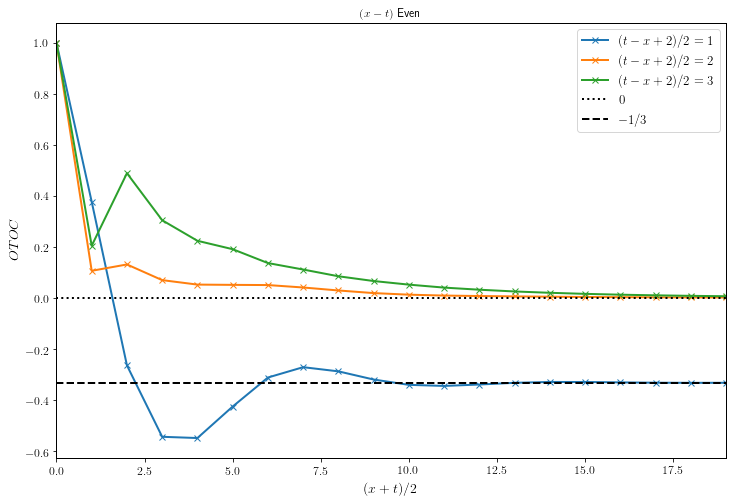

In [13]:
#Get OTOC for even (x-t)
plt.figure()
for n_l in range(1,4):
    [t_range, OTOC_range] = evol_even(U, op_L, op_R, n_l, n_t)
    plt.plot(t_range,OTOC_range.real,'x-',label=r'$(t-x+2)/2=%s$'%n_l)
    #plt.plot(t_range[:-2],OTOC_range.real[2:],'x-',label=r'$n=%s$'%n_l)
   
plt.plot([0.]*n_t,'k:',label='$0$')
plt.plot([-1./3.]*n_t,'k--',label='$-1/3$')
plt.title(r'$(x-t)$ Even')
plt.xlabel(r'$(x+t)/2$')
plt.ylabel(r'$OTOC$')
plt.xlim(0,n_t-1)
plt.legend()
#plt.savefig('OTOC_DualU_even.pdf')
plt.show()

[0.1092+1.8504e-17j 0.1761-4.6259e-18j 0.0445-2.0817e-17j]
0.10933939383620046
0.17619812579293787
0.04425506982105809


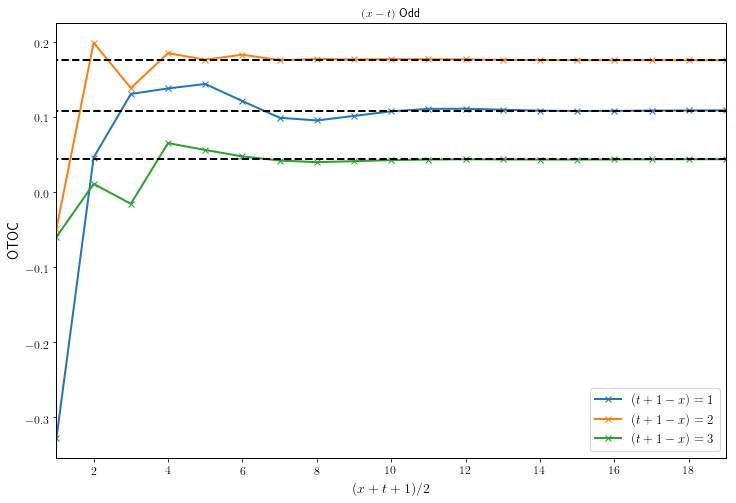

In [14]:
#Get OTOC for odd (x-t)
#Get stationary values of OTOC
n_max = 4
OTOC_f = np.array([OTOC_ss(op_R, U, i) for i in range(1,n_max)])
print(OTOC_f)

plt.figure()
for n_l in range(1,4):
    [t_range, OTOC_range] = evol_odd(U, op_L, op_R, n_l, n_t)
    plt.plot(t_range,OTOC_range.real,'x-',label=r'$(t+1-x)=%s$'%n_l)
    print(OTOC_range.real[-1])
for o_f in OTOC_f:
    plt.plot([o_f.real]*n_t,'k--')
plt.title(r'$(x-t)$ Odd ')
plt.xlabel(r'$(x+t+1)/2$')
plt.ylabel(r'OTOC')
plt.legend()
plt.xlim(1,n_t-1)
#plt.savefig('OTOC_DualU_odd.pdf')
plt.show()    

[1.0920e-01+1.8504e-17j 1.7608e-01-4.6259e-18j 4.4485e-02-2.0817e-17j
 3.5161e-02-8.6736e-18j 2.1505e-02+5.7824e-19j 1.1315e-02-4.3368e-19j
 6.2921e-03-8.6736e-19j 3.5389e-03+7.2280e-19j 1.9679e-03-6.1438e-19j
 1.0949e-03-3.0719e-19j 6.1024e-04-1.8070e-19j 3.3995e-04+1.3553e-19j
 1.8935e-04-1.5811e-20j 1.0547e-04-5.4210e-20j]


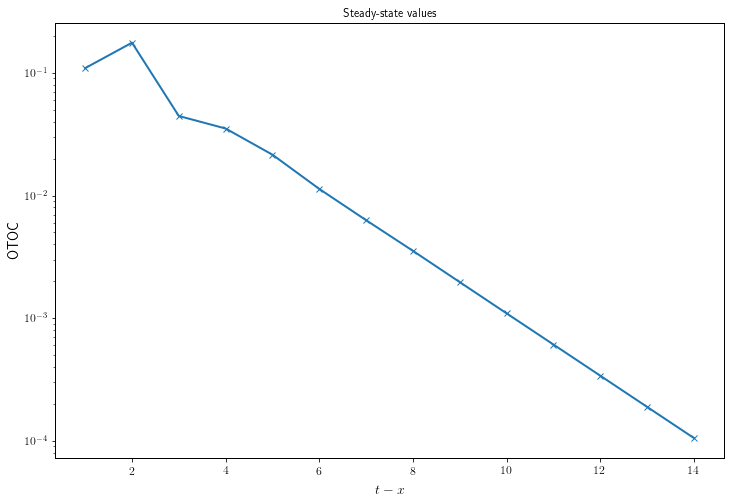

In [15]:
n_max = 15
OTOC_f = np.array([OTOC_ss(op_R, U, i) for i in range(1,n_max)])
print(OTOC_f)
#n_range = np.arange(n_max)

plt.figure()
plt.semilogy(np.arange(1,n_max),np.abs(OTOC_f.real),'x-')
plt.title('Steady-state values')
plt.xlabel(r'$t-x$')
plt.ylabel(r'OTOC')
#plt.savefig('steadystate.pdf')
plt.show()

In [16]:
U = KIM_gate()
op_L, op_R = X, Z
n_t = 40

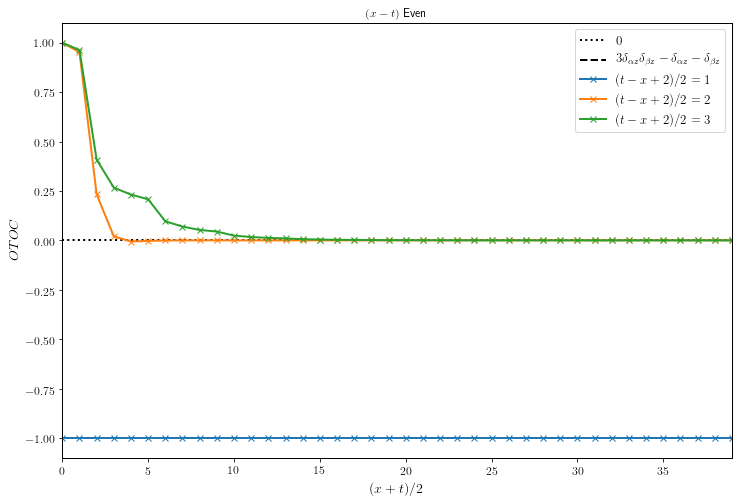

In [17]:
#Get OTOC for even (x-t)
plt.figure()
#Calculate steady-state value on lightcone
delta_az = np.einsum('ab,ba', op_L, Z) / 2.
delta_bz = np.einsum('ab,ba', op_R, Z) / 2.
OTOC_ss = 3.*delta_az*delta_bz - delta_az - delta_bz

plt.plot([0.]*n_t,'k:',label=r'$0$')
plt.plot([OTOC_ss]*n_t,'k--',label=r'$3\delta_{\alpha z}\delta_{\beta z} - \delta_{\alpha z} - \delta_{\beta z}$')

for n_l in range(1,4):
    [t_range, OTOC_range] = evol_even(U, op_L, op_R, n_l, n_t)
    plt.plot(t_range,OTOC_range.real,'x-',label=r'$(t-x+2)/2=%s$'%n_l)
   

plt.title(r'$(x-t)$ Even')
plt.xlabel(r'$(x+t)/2$')
plt.ylabel(r'$OTOC$')
plt.xlim(0,n_t-1)
plt.legend()
#plt.savefig('OTOC_KIM_xz_even.pdf')
plt.show()

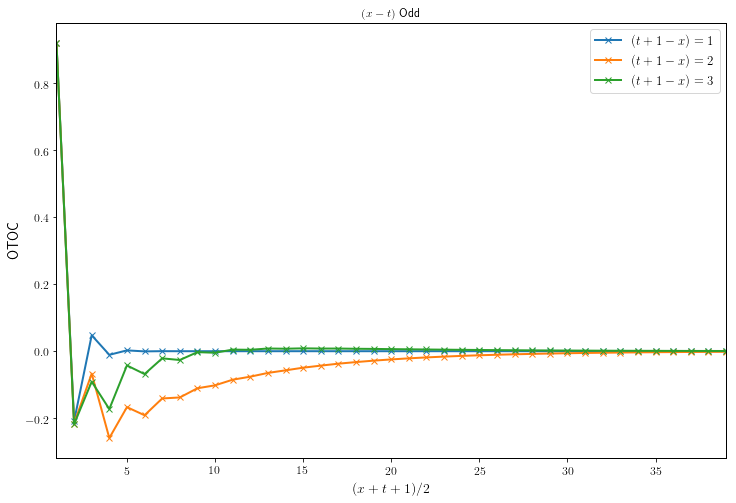

In [18]:
#Get OTOC for odd (x-t)
plt.figure()
for n_l in range(1,4):
    [t_range, OTOC_range] = evol_odd(U, op_L, op_R, n_l, n_t)
    plt.plot(t_range,OTOC_range.real,'x-',label=r'$(t+1-x)=%s$'%n_l)
    
plt.title(r'$(x-t)$ Odd ')
plt.xlabel(r'$(x+t+1)/2$')
plt.ylabel(r'OTOC')
plt.legend()
plt.xlim(1,n_t-1)
#plt.savefig('OTOC_KIM_xz_odd.pdf')
plt.show()    